<a href="https://colab.research.google.com/github/schedldave/aos-scripts/blob/main/Copy_of_Variance_with_Motion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


# utility function(s)
def imshow(image, *args, **kwargs):
    """A replacement for cv2.imshow() for use in Jupyter notebooks using matplotlib.

        Args:
          image : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
            (N, M, 3) is an NxM BGR color image. 
    """
    if len(image.shape) == 3:
      # Height, width, channels
      # Assume BGR, do a conversion  
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw the image
    plt.imshow(image, *args, **kwargs)
    # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
    plt.axis('off')
    # Make sure it outputs
    # plt.show()

A single binary view (area: $w \times w$) is composed of zero background and of a target of size $a \times a$. The mean and variance of such a 2D view are 
$$
\mu = \frac{a^2}{w^2} \\
\sigma = \mu(\mu-1)^2 + (1-\mu)(\mu-0)^2 =  \mu - \mu^2
$$
, where the mean ($\mu$) also describes the size relation of the target with respect to the view. The term $(\mu-1)^2$ is the variance computation in the target and $(\mu-0)^2 = \mu^2$ the variance for the background.

The code below shows such an example:

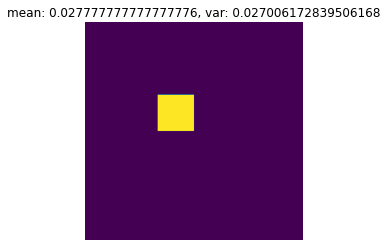

In [8]:
w = 300
a =  50
sx,sy = int(w/3), int(w/3)

single = np.zeros((300,300))
single[sx:sx+a,sy:sy+a] = 1.0

imshow(single)
plt.title( 'mean: {}, var: {}'.format(np.mean(single), np.var(single)))
plt.show()

If multiple such single views are averaged (as typically done in AOS) it has no effect on the variance and mean as long as the target is perfectly registered. 

If the target, however, is not registered (e.g., a moving target or by defocus) the statistics change. 
Let's first look at the extreme case, where the averaged targets are not overlapping anymore. This is showcased below by introducing a shift $d$ for $N$ images.
The mean ($\mu$) is not altered, but the variance changes:
$$
\sigma = N\mu(\mu-\frac{1}{N})^2 + (1-N\mu)(\mu-0)^2 =  \frac{\mu}{N} - \mu^2 \text{.}
$$
The change of $\sigma$ is inverse proportional to $N$. Note that $N\mu$ describes the area covered by the non-overlapping instances of the target. 

0.0044444444444444444


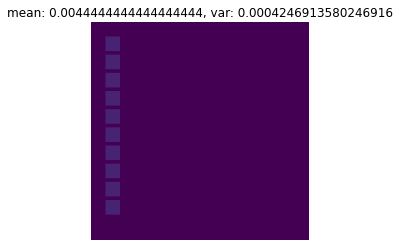

var (non-overlap): 0.00042469135802469137


In [9]:
w = 300
a =  20
r = a*a / w**2 # ratio/mean
print(r)
d = 25
N = 10
sx,sy = int(a), int(a)
sum = np.zeros((w,w))

for i in range(N):
  single = np.zeros((w,w))
  x,y = sx + i*d, sy
  single[x:x+a,y:y+a] = 1.0
  sum += single

sum = sum/N

imshow(sum, vmin=0.0, vmax=1.0)
plt.title( 'mean: {}, var: {}'.format(np.mean(sum), np.var(sum)))
plt.show()

# variance computation
v_overlap = r - r**2
v_nonoverlap = r/N - r**2
print('var (non-overlap): {}'.format( v_nonoverlap ) )


If the shift $d$ is less then the target size $a$ $(d < a)$ the targets will overlap in the integral image. For simplicity we will just look at the problem in 1D now. 
The area (normalized by the area size) that is covered by the non-overlapping targets can be expressed by 
$$
  g = \frac{d(N-1)+a}{w}
$$
and the number of overlaps is expressed by 
$$
  M = \frac{a}{d}
$$
, where it has to be ensured that $M$ does not exceed $N$. 
Furthermore, there will be different regions with a varying amount of overlap. For example a target with $a=5$ a shift of $d=2$ and $N=7$ results in 4 regions without overlap in 8 regions where two target instances overlap and 5 regions with an overlap of three targets. Note that this is illustrated in the example below. Furthermore, in this simulation a region is a pixel or array cell. 

To compute the variance the different overlaps have to be considered. We introduce this as a count $c_i$, where $i$ is the number of overlapping targets. In the example this results in $c_1=4, c_2=8$, and $c_3=5$.
The equation to compute the variance thus expands to
$$
  \sigma = (1-g)\mu^2 + \frac{1}{w} \sum_i c_i (\mu - \frac{i}{N})^2 \\
   =  \mu^2 - \frac{2\mu}{Nw} \sum_i c_i i + \frac{1}{N^2w} \sum_i c_i i^2 \text{.}
$$
By subsituting $\mu = a/w$ it further simplifies to
$$
  \sigma =  \frac{a^2}{w^2} - \frac{2a}{Nw^2} \sum_i{ c_i i }+ \frac{1}{N^2w} \sum_i c_i i^2 \text{.}
$$

Note that it is propably impractical to always compute $c_i$ so it might be possible to simplify or approximate these terms. A first attempt would be to approximate the terms by
$$
 \sum_i{ c_i i }   \approx M (d (N-1-M)+a) \\
 \sum_i{ c_i i^2 } \approx M^2 (d (N-1-M)+a) \text{.}
$$
This, however does not allways lead to close results (see below). 



0.16666666666666666
[13  4  8  5]
[0 1 2 3]


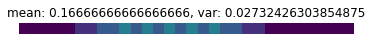

var (new): 0.02732426303854875
var (approx): 0.03117913832199546


In [13]:
w = 30
a =  5
r = a / w # ratio/mean
print(r)
d = 2
N = 7
sx,sy = int(a), int(a)
sum = np.zeros((1,w))

for i in range(N):
  single = np.zeros_like(sum)
  x,y = sx + i*d, sy
  single[:,x:x+a] = 1.0
  sum += single

count,bins=np.histogram(sum, bins=np.arange(np.max(sum)+2))
print(count) 
print(np.asarray(bins[:-1],dtype=np.int16))
sum = sum/N

imshow(sum, vmin=0.0, vmax=1.0)
plt.title( 'mean: {}, var: {}'.format(np.mean(sum), np.var(sum)))
plt.show()

# variance computation
if d<=0:
  M = N
else:
  M = max(min(a/d,N),1)

v_overlap = r - r**2        # assuming everything is overlapping
v_nonoverlap = r/N - r**2   # assuming nothing is overlapping in the integral

term1 = np.sum(bins[:-1] * count)
term2 = np.sum(bins[:-1]**2 * count)
v = a**2/w**2 - 2*a/(N*w**2)*term1 + 1/(N**2*w)*term2
print('var (new): {}'.format( v ) )

# approximate term1 and term2
term1_ = M * (d*(N-1-M)+a)
term2_ = term1_ * M
v_ = a**2/w**2 - 2*a/(N*w**2)*term1_ + 1/(N**2*w)*term2_
print('var (approx): {}'.format( v_ ) )

